In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('final_wo.csv')

# plot the distribution

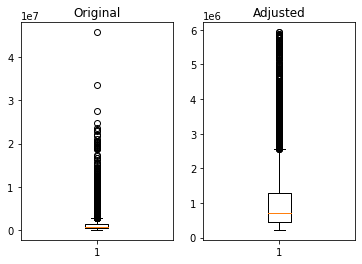

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

pd_series = data['price_T']
pd_series_adjusted = pd_series[pd_series.between(pd_series.quantile(.05), pd_series.quantile(.95))] 

ax1.boxplot(pd_series)
ax1.set_title('Original')

ax2.boxplot(pd_series_adjusted)
ax2.set_title('Adjusted')

plt.show()

In [4]:
sns.set(rc={'figure.figsize':(10,6)})


 mu = 1528756.94 and sigma = 2602758.26



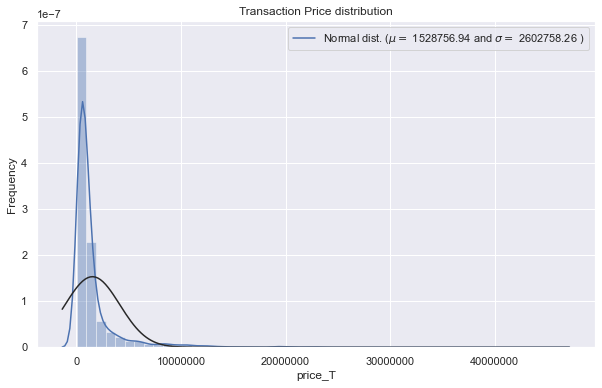

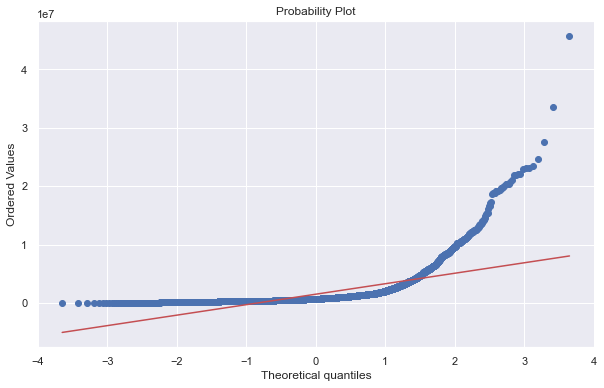

In [5]:
sns.distplot(data['price_T'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['price_T'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Transaction Price distribution')
plt.ticklabel_format(style='plain', axis='x')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['price_T'], plot=plt)

plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Log-transformation of the target variable


 mu = 13.63 and sigma = 0.99



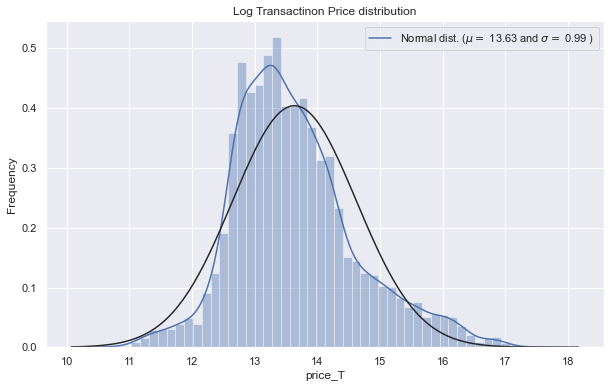

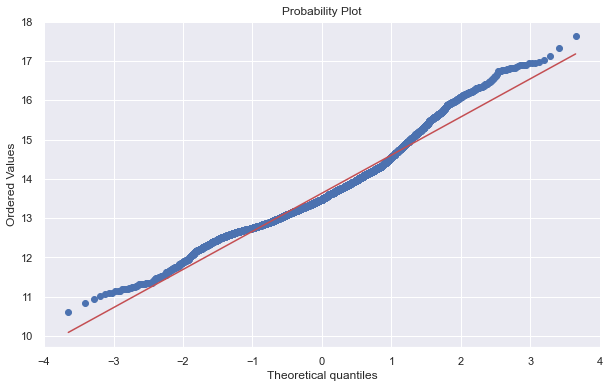

In [6]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data['price_T'] = np.log1p(data['price_T'])

#distribution 
sns.distplot(data['price_T'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['price_T'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log Transactinon Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['price_T'], plot=plt)
plt.show()

# split dataset

In [7]:
data2=data.drop(['Accepted Year', 'NYXRCSA'], axis=1)

In [8]:
data2['Doorman']=data2['Doorman'].fillna(0)
data2['Pets']=data2['Pets'].fillna(0)

In [9]:
data2=data2.drop(['storage', 'common commercial ','administration'], axis=1)

In [10]:
data2['price_T_log']=np.log1p(data2['price_T'])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data2.drop(['price_T_log','Closing Price','price_T','price_T/sq_ft', 'Price_ft2',
                                                               'type','Neighborhood',], axis=1),
                                                   data2['price_T_log'],
                                                   test_size=0.2,
                                                   random_state=0)
X_train.shape, X_test.shape

((4237, 36), (1060, 36))

In [12]:
from sklearn.pipeline import Pipeline
from feature_engine import categorical_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from feature_engine import missing_data_imputers as mdi

In [13]:
miss_col=['common interest','Offering Price','monthli tax','monthli charg common','monthly carrying charges',
'common residential units','payroll','gas/ hot water/heat','electricity','water sewer','services supplies',
'insurance','management','legal and audit','contingency','beds2','baths2']

In [14]:
data_pipeline = Pipeline([
    #imput missing data
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=miss_col)),
    # feature Scaling
    ('scale', MinMaxScaler()) 
])

In [15]:
data_pipeline.fit(X_train,y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['common interest',
                                              'Offering Price', 'monthli tax',
                                              'monthli charg common',
                                              'monthly carrying charges',
                                              'common residential units',
                                              'payroll', 'gas/ hot water/heat',
                                              'electricity', 'water sewer',
                                              'services supplies', 'insurance',
                                              'management', 'legal and audit',
                                              'contingency', 'beds2',
                                              'baths2'])),
                ('scale', MinMaxScaler())])

In [16]:
X_train=data_pipeline.transform(X_train)
X_test=data_pipeline.transform(X_test)

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Linear Regression

In [18]:
lr = LinearRegression().fit(X_train,y_train)

print('LR performance Train: ', lr.score(X_train,y_train))
print('test:',lr.score(X_test,y_test))
mse = mean_squared_error(y_test, lr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print('RMSE:',mse**0.5)

LR performance Train:  0.8960457925756322
test: 0.8947547216403129
The mean squared error (MSE) on test set: 0.0005
RMSE: 0.022405195380703714


# XGB

In [19]:
from xgboost import XGBRegressor
from sklearn import ensemble

In [20]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print('RMSE:',mse**0.5)
print(f'Train score is {reg.score(X_train,y_train)}')
print(f'test score is {reg.score(X_test,y_test)}')

The mean squared error (MSE) on test set: 0.0001
RMSE: 0.010449925301170445
Train score is 0.9942826372760263
test score is 0.9771054810787081


In [21]:
print('train adjust R2: ',1 - (1-reg.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('test adjust R2: ',1 - (1-reg.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))


train adjust R2:  0.9942336313098208
test adjust R2:  0.976299808858604


# feature importance

In [22]:
data3=data2.drop(['Closing Price','price_T','price_T_log','price_T/sq_ft', 'Price_ft2','type','Neighborhood',], axis=1)#'total expenses/Total Apartments'

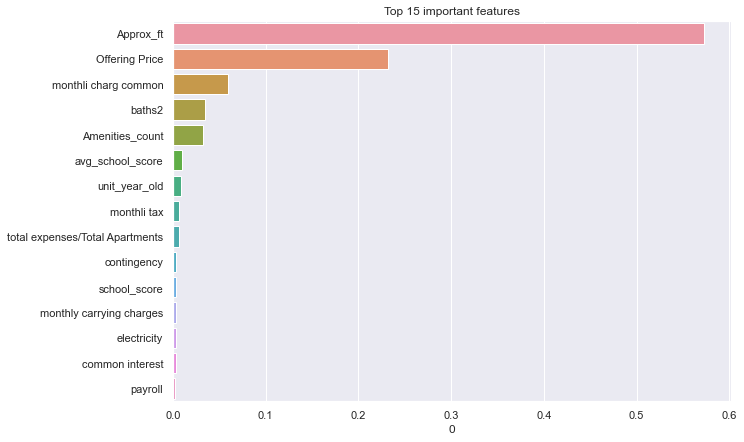

In [23]:
feat_importances = pd.Series(reg.feature_importances_, index=data3.columns)
feat_importances=feat_importances.nlargest(15)
cc=pd.DataFrame(feat_importances).sort_values(by=[0], ascending=False)

fig,ax=plt.subplots(figsize=(10,7))
sns.barplot(cc[0],cc.index)
plt.title("Top 15 important features")
plt.show()

# Residuals Plot

In [24]:
from yellowbrick.regressor import ResidualsPlot

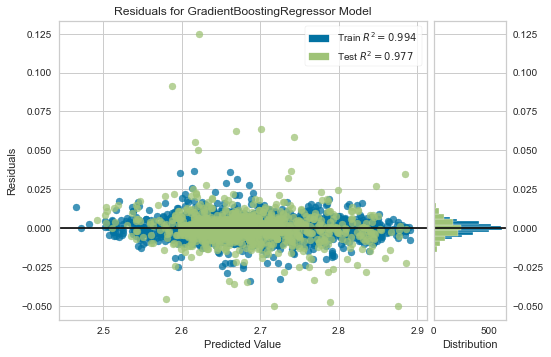

<AxesSubplot:title={'center':'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [25]:
visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 